#  Assignment 2 - Transfer Learning and Data Augmentation 💬

Welcome to the **second assignment** for the **CS-552: Modern NLP course**!

> - 😀 Name: **Emmanouil Chatzakis**
> - ✉️ Email: **emmanouil.chatzakis@epfl.ch**
> - 🪪 SCIPER: **353068**

<div style="padding:15px 20px 20px 20px;border-left:3px solid green;background-color:#e4fae4;border-radius: 20px;">

## **Assignment Description**
- In the first part of this assignment, you will need to implement training (fine-tuning) and evaluation of a pre-trained language model ([DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert) ), on natural language inference (NLI) task for recognizing textual entailment (RTE).

- Following the first finetuning task, you will need to identify the shortcut (i.e. some salient or toxic features) that the model learnt for the specific task. 

- For part-3, you are supposed to annotate 100 randomly assigned test datapoints as ground-truth labels. Additionally, the cross annotation should be conducted by another one or two annotators, and you will learn about how to calculate the agreement statistics as a significant characteristic reflecting the quality of a collected dataset.

- For part-4, since the human annotation is quite time- and effort-consuming, there are plenty of ways to get silver-labels from automatic labeling to augment the dataset scale. We provide the reference to some simple methods (EDA and Back Translation) but you are encouraged to explore other advanced mechanisms. You will evaluate the improvement of your model performance by using your data augmentation method.

For each part, you will need to complete the code in the corresponding `.py` files (`nli.py` for Part-1, `shortcut.py` for Part-2, `eda.py` for Part-4). You will be provided with the function descriptions and detailed instructions about the code snippet you need to write.


### Table of Contents
- **[PART 1: Model Finetuning for NLI](#1)**
    - [1.1 Data Processing](#11)
    - [1.2 Model Training and Evaluation](#12)
- **[PART 2: Identify Model Shortcut](#2)**
    - [2.1 Word-Pair Pattern Extraction](#21)
    - [2.2 Distill Potentially Useful Patterns](#22)
    - [2.3 Case Study](#23)
- **[PART 3: Annotate New Data](#3)**
    - [3.1 Write an Annotation Guideline](#31)
    - [3.2 Annotate Your 100 Datapoints with Partner(s)](#32)
    - [3.3 Agreement Measure](#33)
    - [3.4 Robustness Check](#34)
- **[PART 4: Data Augmentation](#4)**
    
### Deliverables

- ✅ This jupyter notebook
- ✅ `nli.py` file
- ✅ `shortcut.py` file
- ✅ Finetuned DistilBERT models for NLI task (Part 1 and Part 4)
- ✅ Annotated and cross-annotated data files (Part 3)
- ✅ New dataset from data augmentation (Part 4)

</div>

In [16]:
USE_COLAB = True

### Google Colab Setup
If you are using Google Colab notebook for this assignment, you will need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the popped window, sign in to your Google account. (The same account you used to store this notebook!)

In [17]:
if USE_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now first click the 4th left-side bar (named Files), then click the 2nd bar popped under Files column (named Refresh), under "/drive/MyDrive/" find the Assignment 2 folder that you uploaded to your Google Drive, copy its path and fill it in below. If everything is working correctly, then running the folowing cell should print the filenames from the assignment:

```
['Assignment2.ipynb', 'requirements.txt', 'runs', 'predictions', 'nli_data', 'testA2.py', 'nli.py', 'shortcut.py']
```

In [18]:
import os

if USE_COLAB:
    # TODO: Fill in the path where you download the Assignment folder into
    ROOT_PATH = "/content/drive/MyDrive/epfl/modernNLP/a2-MChatzakis/A2"  # Replace with your directory to A2 folder
    print(os.listdir(ROOT_PATH))


['runs', 'nli_data', 'predictions', 'requirements.txt', 'eda.py', 'shortcut.py', 'nli.py', 'testA2.py', 'Assignment2.ipynb', '__pycache__']


Before we start, we also need to run some boilerplate code to set up our environment, same as previous assignments. You'll need to rerun this setup code each time you start the notebook.

In [19]:
if USE_COLAB:
    requirements = ROOT_PATH + "/requirements.txt"
    %pip install -r {requirements}
    %pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu116
    %pip install torchmetrics
    %pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



Run this cell to load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
if USE_COLAB:
    from copy import deepcopy
    import numpy as np
    from tqdm import tqdm
    import jsonlines
    import sys
    import time
    import random

    import torch
    import torch.utils.data
    from torch import nn, optim
    from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
    from transformers import AdamW, get_constant_schedule_with_warmup
    from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

    import itertools
    import pprint

Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello A2!
```

In [22]:
if USE_COLAB:
    GOOGLE_DRIVE_PATH = ROOT_PATH
    sys.path.append(GOOGLE_DRIVE_PATH)

    from testA2 import hello_A2

    hello_A2()


Hello A2!


Note that if CUDA is not enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment.

We will be using `torch.float = torch.float32` for all operations.

Please refer to https://pytorch.org/docs/stable/tensor_attributes.html#torch-dtype for more details about data types.

In [23]:
if USE_COLAB:
    if torch.cuda.is_available():
        print("Good to go!")
    else:
        print("Please set GPU via Edit -> Notebook Settings.")


Good to go!


### Local Setup
If you skip Google Colab setup, you still need to fill in the path where you download the Assignment folder, and install required packages.

In [24]:
if not USE_COLAB:
    ROOT_PATH = "./"  # Replace with your directory to A2 folder
    %pip install jsonlines==3.1.0
    %pip install transformers==4.26.1
    %pip install nltk==3.8.1
    %pip install apex==0.9.10.dev0
    %pip install scikit-learn==1.2.2
    %pip install huggingface-hub==0.12.1
    %pip install numpy==1.22.4
    %pip install tqdm==4.65.0
    %pip install scipy==1.10.1
    %pip install urllib3==1.26.15
    %pip install six==1.16.0
    %pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu116
    %pip install torchmetrics
    %pip install sklearn

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
if not USE_COLAB:
    from copy import deepcopy
    import numpy as np
    from tqdm import tqdm
    import jsonlines
    import sys
    import time, os
    import random

    import torch
    import torch.utils.data
    from torch import nn, optim
    from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
    from transformers import AdamW, get_constant_schedule_with_warmup
    from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
    import itertools
    import pprint


<a name="1"></a>
## **PART 1: Finetuning DistilBERT for NLI**
---

### **What is the NLI task?🧐**
> Given a pair of sentences, denoted as a "premise" sentence and a "hypothesis" sentence, NLI (or RTE) aims to determine their logical relationship, i.e. whether they are logically follow (entailment), unfollow (contradiction) or are undetermined (neutral) to each other.

> Defined as a machine learning task, NLI can be considered as a 3-classes (entailment, contradiction, or neutral) classification task, with a sentence-pair input ("hypothesis" and “premise”).

> **You can run the following cell to have the first glance at your data**. Each data sample is a python dictionary, which consists of following components:
- premise sentence (*'premise'*), 
- hypothesis sentence (*'hypothesis'*) 
- domain (*'domain'*): describing the topic of premise and hypothesis sentences (e.g., government regulations, telephone talks, etc.)
- label (*'label'*): indicating the logical relation between premise and hypothesis (i.e., entailment, contradiction, or neutral).

In [27]:
# If you use Google Colab, then data_dir = 'GOOGLE_DRIVE_PATH/nli_data'
data_dir = ROOT_PATH + "/nli_data"
data_dev_path = os.path.join(data_dir, "dev_in_domain.jsonl")
with jsonlines.open(data_dev_path, "r") as reader:
    for sid, sample in enumerate(reader.iter()):
        print(sample)
        if sid == 2:
            break


{'premise': 'The new rights are nice enough', 'hypothesis': 'Everyone really likes the newest benefits ', 'domain': 'slate', 'label': 'neutral'}
{'premise': 'This site includes a list of all award winners and a searchable database of Government Executive articles.', 'hypothesis': 'The Government Executive articles housed on the website are not able to be searched.', 'domain': 'government', 'label': 'contradiction'}
{'premise': "uh i don't know i i have mixed emotions about him uh sometimes i like him but at the same times i love to see somebody beat him", 'hypothesis': 'I like him for the most part, but would still enjoy seeing someone beat him.', 'domain': 'telephone', 'label': 'entailment'}


In [28]:
# Enter enter your Sciper number
SCIPER = "353068"
seed = int(SCIPER)
torch.backends.cudnn.deterministic = True


In [29]:
print("Your random seed is: ", seed)


Your random seed is:  353068


In [30]:
# We use the following pretrained tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

### **1.1 Dataset Processing**
Our first step is to load datasets for NLI task by constructing a Pytorch Dataset. Specifically, we will need to implement tokenization and padding with a HuggingFace pre-trained tokenizer.

**Complete `NLIDataset` class following the instructions in `nli.py`, and test by running the following cell.**

In [31]:
from nli import NLIDataset

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
dataset = NLIDataset(ROOT_PATH + "/nli_data/dev_in_domain.jsonl", tokenizer)

from testA2 import test_NLIDataset

test_NLIDataset(dataset)


Building NLI Dataset...


9815it [00:07, 1314.88it/s]

NLIDataset test correct ✅


### **1.2 Model Training and Evaluation**
Next, we will implement the training and evaluation process to finetune the model. For model training, you will need to calculate the loss and update the model weights by update the optimizer. Additionally, we add a learning rate schedular to adopt an adaptive learning rate during the whole training process. 

For evaluation, you will need to compute accuracy and F1 scores to assess the model performance. 

**Complete the `compute_metric()`, `train()` and `evaluate()` functions following the instructions in the `nli.py` file, you can test compute_metric() by running the following cell.**

In [32]:
from nli import compute_metrics, train, evaluate

from testA2 import test_compute_metrics

test_compute_metrics(compute_metrics)


compute_metric test correct ✅


#### **Start Training and Validation!**

Try the following different hyperparameter settings, compare and discuss the results. (Other hyperparameters should not be changed.)

> A. learning_rate 2e-5

> B. learning_rate 5e-5

**Note:** *Each training will take about 1 hour using a GPU, please keep your computer and notebook active during the training.*

**Questions: Which learning rate is better? Explain your answers.**

In [33]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to(device)

train_dataset = NLIDataset(ROOT_PATH + "/nli_data/train.jsonl", tokenizer)
dev_dataset = NLIDataset(ROOT_PATH + "/nli_data/dev_in_domain.jsonl", tokenizer)

batch_size = 16
epochs = 3
max_grad_norm = 1.0
warmup_percent = 0.3
model_save_root = ROOT_PATH + "/runs/"


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

Building NLI Dataset...


98176it [01:50, 884.68it/s] 


Building NLI Dataset...


9815it [00:10, 928.51it/s] 


In [ ]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

lr_option_1 = 2e-5
lr_option_2 = 5e-5

print(f"Training with first lr={lr_option_1}")
train(
    train_dataset,
    dev_dataset,
    model,
    device,
    batch_size,
    epochs,
    lr_option_1,
    warmup_percent,
    max_grad_norm,
    model_save_root,
)

print("\n\n================\n\n")

print(f"Training with first lr={lr_option_2}")
train(
    train_dataset,
    dev_dataset,
    model,
    device,
    batch_size,
    epochs,
    lr_option_2,
    warmup_percent,
    max_grad_norm,
    model_save_root,
)


Training with first lr=2e-05


Evaluation: 100%|██████████| 614/614 [00:24<00:00, 25.49it/s]


Epoch: 0 | Training Loss: 0.714 | Validation Loss: 0.609
Epoch 0 NLI Validation:
Accuracy: 75.68% | F1: (79.23%, 70.25%, 76.77%) | Macro-F1: 75.42%
Model Saved!


Evaluation: 100%|██████████| 614/614 [00:24<00:00, 25.50it/s]


Epoch: 1 | Training Loss: 0.464 | Validation Loss: 0.594
Epoch 1 NLI Validation:
Accuracy: 77.63% | F1: (80.78%, 73.40%, 78.25%) | Macro-F1: 77.48%
Model Saved!


Evaluation: 100%|██████████| 614/614 [00:24<00:00, 25.52it/s]


Epoch: 2 | Training Loss: 0.242 | Validation Loss: 0.743
Epoch 2 NLI Validation:
Accuracy: 76.31% | F1: (79.63%, 72.10%, 77.03%) | Macro-F1: 76.26%
Model Saved!




Training with first lr=5e-05


Evaluation: 100%|██████████| 614/614 [00:24<00:00, 25.45it/s]


Epoch: 0 | Training Loss: 0.364 | Validation Loss: 0.646
Epoch 0 NLI Validation:
Accuracy: 76.22% | F1: (79.52%, 71.23%, 77.24%) | Macro-F1: 76.00%
Model Saved!


Evaluation: 100%|██████████| 614/614 [00:24<00:00, 25.45it/s]


Epoch: 1 | Training Loss: 0.251 | Validation Loss: 0.846
Epoch 1 NLI Validation:
Accuracy: 75.98% | F1: (78.60%, 71.82%, 77.45%) | Macro-F1: 75.96%
Model Saved!


Evaluation: 100%|██████████| 614/614 [00:24<00:00, 25.52it/s]


Epoch: 2 | Training Loss: 0.203 | Validation Loss: 1.098
Epoch 2 NLI Validation:
Accuracy: 75.31% | F1: (78.43%, 70.89%, 76.29%) | Macro-F1: 75.21%
Model Saved!


**Learning Rate Comparison**

The model training with lr=2e-05 has better overall performance (76% accuracy and macro-f1) compared to the model with lr=5e-05 (75% accuracy and macro-f1). 
This happens because models with lower learning rate tend to converge smoother to a minimum, exploring the loss landscape extensively, and dodging the danger of skipping a good convergence point because of the higher "jumps" that a bigger learning rate may cause. However, because of the smaller steps that lower learning rates lead to, the model training might require more time to train.

### **Fine-Grained Validation**

Use the model checkpoint saved under the first hyperparameter setting (learning_rate 2e-5) in 1.4, check the model performance on each domain subsets of the validation set, report the validation loss, accuracy, F1 scores and Macro-F1 on each domain, compare and discuss the results.

**Questions: On which domain does the model perform the best? the worst? Give some possible explanations of why the model's best-performed domain is easier, and why the model's worst-performed domain is more challenging. Use some examples to support your explanations.**

**Note:** To find examples for supporting your discussion, save the model prediction results on each domain under the './predictions/' folder, by specifying the *result_save_file* of the *evaluate* function.

In [34]:
batch_size = 16
learning_rate = 2e-5
warmup_percent = 0.3
checkpoint = ROOT_PATH + "/runs/lr{}-warmup{}".format(learning_rate, warmup_percent)

# Split the validation sets into subsets with different domains
# Save the subsets under './nli_data/'
# Replace "..." with your code

raw_data = dev_dataset.text_samples
subsets = {}

# Gather the subsets in files
for index, raw_sample in enumerate(raw_data):
    domain = raw_sample["domain"]
    if domain in subsets:
        subsets[domain] = subsets[domain] + [raw_sample]
    else:
        subsets[domain] = [raw_sample]

# Check prints and dumping data to partial files
total = 0
for domain in subsets.keys():
    filename = ROOT_PATH + "/nli_data/" + "dev_in_domain" + "_" + domain + ".jsonl"

    # Dump to file
    with jsonlines.open(filename, "w") as writer:
        writer.write_all(subsets[domain])

    print(f"Samples in {domain}: {len(subsets[domain])}, saved in file: {filename}")
    total += len(subsets[domain])

# Sanity Check
assert total == len(raw_data)


Samples in slate: 1955, saved in file: /content/drive/MyDrive/epfl/modernNLP/a2-MChatzakis/A2/nli_data/dev_in_domain_slate.jsonl
Samples in government: 1945, saved in file: /content/drive/MyDrive/epfl/modernNLP/a2-MChatzakis/A2/nli_data/dev_in_domain_government.jsonl
Samples in telephone: 1966, saved in file: /content/drive/MyDrive/epfl/modernNLP/a2-MChatzakis/A2/nli_data/dev_in_domain_telephone.jsonl
Samples in travel: 1976, saved in file: /content/drive/MyDrive/epfl/modernNLP/a2-MChatzakis/A2/nli_data/dev_in_domain_travel.jsonl
Samples in fiction: 1973, saved in file: /content/drive/MyDrive/epfl/modernNLP/a2-MChatzakis/A2/nli_data/dev_in_domain_fiction.jsonl


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint)
model.to(device)

for domain in ["fiction", "government", "slate", "telephone", "travel"]:
    # Evaluate and save prediction results in each domain
    # Replace "..." with your code
    filename = ROOT_PATH + "/nli_data/" + "dev_in_domain" + "_" + domain + ".jsonl"
    dev_domain_dataset = NLIDataset(filename, tokenizer)

    predictions_file = ROOT_PATH + "/predictions/predictions_" + domain + ".txt"
    dev_loss, acc, f1_ent, f1_neu, f1_con = evaluate(
        dev_domain_dataset,
        model,
        device,
        batch_size,
        no_labels=False,
        result_save_file=predictions_file,
    )
    macro_f1 = (f1_ent + f1_neu + f1_con) / 3

    print(f"Domain: {domain}")
    print(f"Validation Loss: {dev_loss:.3f} | Accuracy: {acc*100:.2f}%")
    print(
        f"F1: ({f1_ent*100:.2f}%, {f1_neu*100:.2f}%, {f1_con*100:.2f}%) | Macro-F1: {macro_f1*100:.2f}%"
    )


Building NLI Dataset...


1973it [00:00, 4418.74it/s]
Evaluation: 100%|██████████| 124/124 [00:19<00:00,  6.39it/s]


Domain: fiction
Validation Loss: 0.734 | Accuracy: 76.53%
F1: (78.31%, 72.70%, 78.55%) | Macro-F1: 76.52%
Building NLI Dataset...


1945it [00:00, 2731.55it/s]
Evaluation: 100%|██████████| 122/122 [00:23<00:00,  5.09it/s]


Domain: government
Validation Loss: 0.653 | Accuracy: 80.26%
F1: (83.78%, 76.22%, 80.48%) | Macro-F1: 80.16%
Building NLI Dataset...


1955it [00:00, 2974.60it/s]
Evaluation: 100%|██████████| 123/123 [00:24<00:00,  5.07it/s]


Domain: slate
Validation Loss: 0.873 | Accuracy: 71.20%
F1: (74.06%, 67.23%, 72.27%) | Macro-F1: 71.19%
Building NLI Dataset...


1966it [00:00, 3324.58it/s]
Evaluation: 100%|██████████| 123/123 [00:27<00:00,  4.55it/s]


Domain: telephone
Validation Loss: 0.765 | Accuracy: 74.57%
F1: (78.53%, 68.67%, 76.33%) | Macro-F1: 74.51%
Building NLI Dataset...


1976it [00:00, 2827.14it/s]
Evaluation: 100%|██████████| 124/124 [00:22<00:00,  5.49it/s]

Domain: travel
Validation Loss: 0.679 | Accuracy: 78.39%
F1: (82.36%, 75.06%, 77.54%) | Macro-F1: 78.32%


**Comments**

Among the by-domain test sets, the model performs best for the "government" domain, with accuracy=80% and macro-f1=80%. Also, the worst performance of the model is for the "slate" domain, with accuracy=71% and macro-f1=71%.

By analyzing the training data, we see that the samples of "government" are approximately 19.000, same as the "slate" samples, while the corresponding test sets of both domains are balanced on the entries of samples labelled as {entailment, contradiction, neutral} (approximately 600-700 per class). Moreover, the total testing samples per domain are also balanced, containing approximately 2000 test samples for each domain.

Thus, given that both test dataset contain balanced number of classes, and the number of training examples are the same for both domains, an explanation regarding this performance difference could be the following:

The training examples that belong to "government" domain are representative examples to what the model encounters during training, managing to classify them with better accuracy. On the other hand, this is not the case for "slate" domain, as the test samples differ from what the model has seen during training, leading to worst performance when testing. 

This happens, for example, when the model tries to classify pairs of sentences that are representative examples to what it has encountered during training. 

This phenomenon shows how important is to have representative and inclusive training data, in order to give the model enough power to classify sentences of different types.




## **Task2: Identify Shortcuts**

We aim to find some shortcuts that the model in 1.4 (under the first hyperparameter setting) has learned.

### **2.1 Word-Pair Pattern Extraction**

We consider to exatrct simple word-pair patterns that the model may have learned from the NLI data. 

For this, we assume that a pair of words that occur in a premise-hypothesis sentence pair (one occurs in premise and the other occurs in hypothesis) may serve as a key indicator of the logical relationship between the premise and hypothesis sentences. For example:

>- Premise: Consider the United States Postal Service.
>- Hypothesis: Forget the United States Postal Service.

Here the word-pair "consider" and "forget" determine that the premise and hypothesis have a *contradiction* relationship, so (consider, forget) --> *contradiction* might be a good pattern to learn.

**Note:** 
- We do not consider the naive word pair patterns where the word from premise and the word from hypothesis are identical, e.g., (service, service) got from the above premise-hypothesis sentence pair.
- We do not consider stop words neither, punctuations and words that contain special prefix '##', e.g., '##s' in the pattern extraction.

In [35]:
# stop_words and puntuations to be removed from consideration in the pattern extraction

import nltk

nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words("english")
stop_words.append("uh")

import string

puncs = string.punctuation


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Complete `word_pair_extraction()` function in `shortcut.py` file.**

The keys of the returned dictionary *word_pairs* should be **different word-pairs** appered in premise-hypothesis sentence pairs, i.e., (a word from the premise, a word from the hypothesis).

The value of a word-pair key records the counts of entailment, neutral and contradiction predictions **made by the model** when the word-pair occurs, i.e., \[#entailment_predictions, #neutral_predictions,  #contradiction_predictions\].

**Note:** Remember to remove naive word pairs (i.e., premise word identical to hypothesis word), stop_words, puntuations and words with special prefix '##' out of consideration.

### **2.2 Distill Potentially Useful Patterns**

Find and print the **top-100** word-pairs that are associated with the **largest total number** of model predictions, which might contain frequently used patterns.

In [36]:
from shortcut import word_pair_extraction, get_representatives, plot_all

In [37]:
def get_topK(dict_data, K=100):
    return dict(itertools.islice(dict_data.items(), K))


# all your saved model prediction results in 1.2 Fine-Grained Validation
prediction_files = [
    ROOT_PATH + "/predictions/predictions_" + domain + ".txt"
    for domain in ["fiction", "government", "slate", "telephone", "travel"]
]

tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
word_pairs = word_pair_extraction(prediction_files, tokenizer)

# find top-100 word-pairs associated with the largest total number of model predictions
sorted_pairs = dict(sorted(word_pairs.items(), key=lambda x: sum(x[1]), reverse=True))
top_100_freq_pairs = get_topK(sorted_pairs)

print("Top100 result frequent pair IDs:")
print(top_100_freq_pairs)

Top100 result frequent pair IDs:
{(2578, 3423): [22, 19, 20], (3423, 2578): [19, 12, 19], (2113, 2051): [23, 13, 10], (10690, 2326): [16, 11, 14], (2326, 10690): [14, 10, 13], (2113, 2111): [17, 17, 2], (2113, 2769): [13, 15, 8], (2113, 2066): [17, 10, 9], (2113, 2843): [17, 13, 5], (2113, 3422): [20, 4, 11], (3398, 2066): [10, 11, 12], (2197, 2086): [15, 6, 10], (2113, 2191): [13, 7, 11], (2113, 2131): [9, 11, 9], (2052, 2071): [6, 11, 11], (2066, 2228): [16, 10, 1], (2113, 2196): [1, 2, 24], (3398, 2028): [7, 7, 13], (2095, 2197): [10, 5, 11], (3398, 2051): [7, 12, 7], (2066, 2843): [11, 11, 3], (2113, 10047): [7, 8, 10], (2113, 2052): [5, 11, 9], (2113, 2228): [5, 17, 3], (2113, 2175): [11, 7, 7], (2028, 2111): [9, 9, 6], (3231, 22423): [8, 8, 8], (3398, 2196): [5, 1, 18], (3398, 2131): [9, 9, 6], (2034, 5653): [4, 10, 9], (2113, 2092): [9, 7, 7], (2113, 2336): [11, 7, 5], (2228, 2052): [4, 8, 10], (2116, 2111): [9, 3, 10], (2052, 2111): [7, 11, 4], (2071, 2052): [6, 4, 12], (2092, 

**Among the top-100 frequent word-pairs above**, find out the **top-5** word-pairs whose occurances **most likely** lead to *entailment* predictions (entailment patterns), and the **top-5** word-pairs whose occurances **most likely** lead to *contradiction* predictions (contradiction patterns).

**Explain your rules for finding these word pairs.**

In [38]:
# find top-5 entailment and contradiction patterns
top_5_entailment_naive = get_topK(
    dict(sorted(word_pairs.items(), key=lambda x: x[1][0], reverse=True)), 5
)

top_5_contradict_naive = get_topK(
    dict(sorted(word_pairs.items(), key=lambda x: x[1][2], reverse=True)), 5
)

print("Entailment Patterns:")
print(top_5_entailment_naive)
print("Contradiction Patterns:")
print(top_5_contradict_naive)

Entailment Patterns:
{(2113, 2051): [23, 13, 10], (2578, 3423): [22, 19, 20], (2113, 3422): [20, 4, 11], (3423, 2578): [19, 12, 19], (2113, 2111): [17, 17, 2]}
Contradiction Patterns:
{(2113, 2196): [1, 2, 24], (2578, 3423): [22, 19, 20], (3423, 2578): [19, 12, 19], (3398, 2196): [5, 1, 18], (2066, 2196): [3, 2, 16]}


The task above is a naive implementation of the question, that just sorts and gets the top 5 entries that have the highest number of occurences in samples of contradiction and entailment.

We see that although this method returns the shortcut pairs that have many occurences in the desired classification type, many entries have many occurences in all possible classes, which does not guarantee that the model will classify them as the class that has the highest number of counts. 

Thus, we need to develop a better way to locate such entries.

In [39]:
# find top-5 entailment and contradiction patterns
top_5_entailment = get_topK(
    dict(
        sorted(
            word_pairs.items(),
            key=lambda x: (x[1][0] - (x[1][1] + x[1][2])),
            reverse=True,
        )
    ),
    5,
)

top_5_contradict = get_topK(
    dict(
        sorted(
            word_pairs.items(),
            key=lambda x: (x[1][2] - (x[1][1] + x[1][0])),
            reverse=True,
        )
    ),
    5,
)

print("Entailment Patterns:")
print(top_5_entailment)
print("Contradiction Patterns:")
print(top_5_contradict)

Entailment Patterns:
{(2592, 2110): [17, 0, 0], (7340, 5324): [11, 0, 0], (2113, 2307): [12, 0, 2], (2592, 5836): [10, 0, 0], (2592, 2708): [10, 0, 0]}
Contradiction Patterns:
{(2113, 2196): [1, 2, 24], (3398, 2196): [5, 1, 18], (2066, 2196): [3, 2, 16], (2051, 2196): [0, 2, 12], (2092, 2196): [2, 1, 13]}


The snippet above is a rule-based implementation of the question. It tries to find the shortcut pairs that seem to appear mostly in only one class case. This is implemented by substracting from the counter we are interested the other two counters.

We see that we actually get shortcut pairs that appear only or mostly in only one type of class, which means that this method is sufficient for our task.

### **2.3 Case Study**

Find out and study **4 representative** cases where the pattern that you have found in 2.2 **fails**, e.g., the premise-hypothesis sentence pair contains ('good', 'bad'), but has an *entailment* gold label.

**Based on your case study, explain the limitations of the word-pair patterns.**

In [40]:
# you can fill your code for finding cases here

# First, we decode the results to be able to understand the results better and interact
# with the dataset easily.

# The analysis below is based on the top5 entries retrieved in previous task.
id_to_label = {"entailment": 0, "neutral": 1, "contradiction": 2}
decoded_entailment = {}
for entry in top_5_entailment:
    tokens = tokenizer.convert_ids_to_tokens([entry[0], entry[1]])
    tok1 = tokens[0]
    tok2 = tokens[1]
    decoded_entailment[(tok1, tok2)] = ["entailment", top_5_entailment[entry]]
decoded_entailment = [
    (d[0][0], d[0][1], d[1][0], d[1][1]) for d in decoded_entailment.items()
]

decoded_contradiction = {}
for entry in top_5_contradict:
    tokens = tokenizer.convert_ids_to_tokens([entry[0], entry[1]])
    tok1 = tokens[0]
    tok2 = tokens[1]
    decoded_contradiction[(tok1, tok2)] = ["contradiction", top_5_contradict[entry]]
decoded_contradiction = [
    (d[0][0], d[0][1], d[1][0], d[1][1]) for d in decoded_contradiction.items()
]

print("Decoded Entailment Pairs:")
pprint.pprint(decoded_entailment)

print("\n ======= \n")
print("Decoded Contradiction Pairs:")
pprint.pprint(decoded_contradiction)

Decoded Entailment Pairs:
[('information', 'state', 'entailment', [17, 0, 0]),
 ('shops', 'stores', 'entailment', [11, 0, 0]),
 ('know', 'great', 'entailment', [12, 0, 2]),
 ('information', 'represents', 'entailment', [10, 0, 0]),
 ('information', 'chief', 'entailment', [10, 0, 0])]


Decoded Contradiction Pairs:
[('know', 'never', 'contradiction', [1, 2, 24]),
 ('yeah', 'never', 'contradiction', [5, 1, 18]),
 ('like', 'never', 'contradiction', [3, 2, 16]),
 ('time', 'never', 'contradiction', [0, 2, 12]),
 ('well', 'never', 'contradiction', [2, 1, 13])]


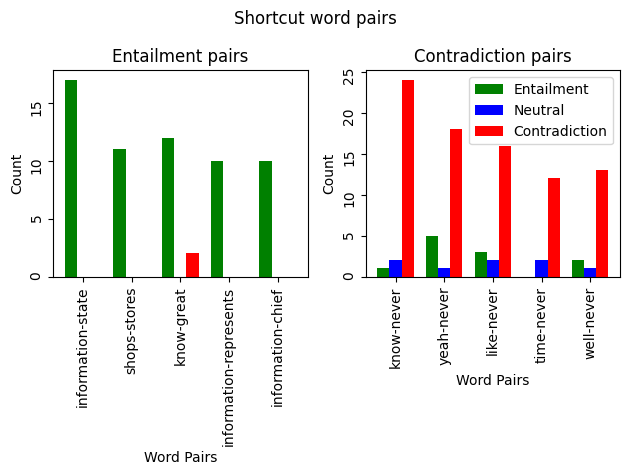

In [41]:
# Now, we can plot them to see more clearly what is going on with our
# selected pairs

plot_all(decoded_entailment, decoded_contradiction)

Now, after the initial analysis we did, we traverse the dataset to find the 4 representative cases of the shortcut phenomenon. Indeed, we seek cases where the model encountered one of the top5 (entailment or contradiction) pairs we found above, but made a wrong prediction because the label was actually different.

Please note that I found 4 examples of sample that have different gold label than what the shortcut indicates, and the model also fails to classify the sample correctly, whenever it was possible.

In [42]:
# Entailement cases
print(f"-Entailment case for pair {decoded_entailment[2]}:")
reps = get_representatives(prediction_files, decoded_entailment[2], tokenizer, True, 2)

pprint.pprint(reps[0])
print()
pprint.pprint(reps[1])


-Entailment case for pair ('know', 'great', 'entailment', [12, 0, 2]):
{'domain': 'telephone',
 'hypothesis': "We have money on there, which isn't great",
 'label': 'contradiction',
 'prediction': 'entailment',
 'premise': 'you know we keep a couple hundred dollars um if that much charged '
            "on those which isn't too bad it's just your normal"}

{'domain': 'telephone',
 'hypothesis': 'Life will be great for subsequent generations if our '
               'generation goes without debt.',
 'label': 'neutral',
 'prediction': 'entailment',
 'premise': "yes they would they just wouldn't be able to own the kind of "
            'automobiles that they think they deserve to own or the kind of '
            'homes that we think we deserve to own we might have to you know '
            'just be able to i think if we a generation went without debt then '
            'the next generation like if if our our generation my husband and '
            "i we're twenty eight if we lived our live

In [43]:
# Contradiction cases
print(f"-Contradiction case for pair {decoded_contradiction[1]}:")
pprint.pprint(
    get_representatives(prediction_files, decoded_contradiction[1], tokenizer, True, 1)[
        0
    ]
)

print(f"\n-Contradiction case for pair {decoded_contradiction[4]}:")
pprint.pprint(
    get_representatives(prediction_files, decoded_contradiction[4], tokenizer, True, 1)[
        0
    ]
)
print()
pprint.pprint(
    get_representatives(
        prediction_files, decoded_contradiction[4], tokenizer, False, 3
    )[1]
)


-Contradiction case for pair ('yeah', 'never', 'contradiction', [5, 1, 18]):
{'domain': 'telephone',
 'hypothesis': "That's amazing, I've never seen anything like it.",
 'label': 'neutral',
 'prediction': 'contradiction',
 'premise': "uh-huh uh-huh uh-huh yeah well that's really neat"}

-Contradiction case for pair ('well', 'never', 'contradiction', [2, 1, 13]):
{'domain': 'telephone',
 'hypothesis': "That's amazing, I've never seen anything like it.",
 'label': 'neutral',
 'prediction': 'contradiction',
 'premise': "uh-huh uh-huh uh-huh yeah well that's really neat"}

{'domain': 'telephone',
 'hypothesis': 'Camping is something that I never got the hang of, though I '
               'took the children fishing, we never did do camping.',
 'label': 'entailment',
 'prediction': 'entailment',
 'premise': 'well camping is one thing that i i could never get used to uh i i '
            'used to take the kids to go fishing and things like that but i '
            'never went uh never went ca

**Interpretation**
- ('know', 'great'): Entailment. We provide two samples that indicate the shortcut failure (in the corresponding output cell above). 
    * The first sample, although it contains the entailment shortcut pair, it is labelled as a contradiction, and the model also fails to classify it correctly. 
    * The second sample, is a similar case as the first, because it is labelled as neutral, but the model classifies it as an entailment case, which is wrong.

- ('yeah', 'never'): Contradiction. We provice a sample that indicates the fail of the contradiction shortcut (in the correspodning cell above). We see that the sentence is labelled as neutral, but the model fails and classifies it as a contradiction, as the shortcut indicates.

- ('well', 'never'): Contradiction. Same as above, we provide a sample that is again labelled as a neutral case, but the model classifies it as a contradiction. Interestingly, this sample is the same sample of ('yeah', 'never') pair, so we located a double failure. Note that in order to be complete, we provide another available sample we found. The second sample is a case were the relationship of the sentences is classified as an entailment, but the model manages to classify it correctly.

**Limitations of Shortcuts**

As we see, there can be cases that shortcuts fail to encapsulate the relationship of all the sentences that they appear. This limitation of such word-pairs is expected, as it is very difficult to include the whole relation of two sentences with just a pair of words. Such pairs are not able to provide the whole context between two sentences, which is an important drawback/limitation, because when we compare two sentences to determine their relationship, the overall context of the text is what gives the most reliable answer in the classification between neutral, contradiction and entailment classes.

## **Task3: Annotate New Data**

To check the robustness of developed model, **some additional sets of test data** are collected (under /nli_data/test_data/), which contain NLI samples that are out of the domains of the training and validation data.

However, the test data does not have gold labels of the relationships between premise and hypothesis sentences, i.e., all the labels are marked as *hidden*. **We consider to annotate the data by ourselves.**

### **3.1 Write an Annotation Guideline**

Imagine that you are going to assign this annotation task to a crowdsourcing worker, who is completely not familiar with computer science and NLP. Think about how you are going to explain this annotation task to him in order to guide him do a decent job. Write an annotation guideline for such a worker who are going to do this task for you.

**Note:** You should come up with your own guideline without the help of your partner(s) in later Task 3.2

**Data Annotation Description**

In order to assign a data annotation task to the crowd, which may be unfamiliar with NLP and computer science, one needs to design a concrete set of rules and guidelines in order to define how the sentences should be labelled.

First of all, we shall give a clear description about what the task is and what we expect from the crowd to do:

- Task Description: We have gathered multiple pairs of sentences from different sources, and we want to label their relationship, by deciding if two sentences are a case of contradiction, entailment or neutral relationship. You will be given a set of such pairs, and you should fill the missing "label" field with the relation that best describes these two sentences.

Next, we should explain what entailment, contradiction and neutral relation is, so that it is clear and has the same meaning for all participants.

- Sentence relationship types: We mentioned above that the three possible relationships that the sentence share are: Entailment, Contradiction and Neutral. Below, you will find a description about each type/class:
    * Entailment: Sentences that one implies the other. For example, the sentences "I like apples" and "I love apples" would be annotated as entailment. This category also includes sentences that one paraphrases the other.
    * Contradiction: Sentences that have opposite meaning. For example, the sentences "I am feeling good" and "I am feeling bad" should be annotated as contradiction.
    * Neutral: Sentences that share no logical relationship. For example, the sentences "The sky is blue" and "I like books" would be annotated as neutral.

Now that we have described the task and the three possible classes of sentences, we are ready to give our annotation guideline.

- Annotation Guideline:
    1. Read multiple types the given pair of sentences, and try to fully understand their meaning, based on the whole context of each sentence.
    2. Following the aforementioned rules, try to determine if those sentences have opposite meanings, if they imply each other or if there is no logical relationship between them.
        * If you are not sure, you may suppose that they share "neutral" relationship.
        * Please be extremely careful when extracting the meaning of a sentence: You may focus on the whole sentence, not in single words.
    3. Based on your class selection ("entailment", "contradition", "neutral"), fill the field "gold_label" of the corresponding pair.
    4. Repeat the guideline steps for all the pairs assigned to you.

### **3.2 Annotate Your 100 Datapoints with Partner(s)**

Annotate your 100 test datapoints with your partner(s), by editing the value of the key "label_student1", "label_student2" and "label_student3" (if you are in a group of three students) in each datapoint.

**Note:** 
- You can download the assigned annotation file (`<your-testset-id>.jsonl`) by [this link](https://drive.google.com/drive/folders/146ExExmpnSUayu6ArGiN5gQzCPJp0myB?usp=share_link)
- Please find your annotation partner according to the "Student Pairing List for A2 Task3" shared on Ed.

**Name your annotated file as `<index>-<sciper_number>.jsonl`.** 

For example, if you get `01.jsonl` to annotate, you should name your deliverable as `01-<your_sciper_number>.jsonl`.

### **3.3 Agreement Measure**

Based on your and your partner's annotations on the 100 test datapoints in 3.2, calculate the [Cohen's Kappa](https://scikit-learn.org/stable/modules/model_evaluation.html#cohen-kappa) or [Krippendorff's Alpha](https://github.com/pln-fing-udelar/fast-krippendorff) (if you are in a group of three students) between the annotators. Discuss the agreement measure results.

**Note:** Cohen's Kappa or Krippendorff's Alpha interpretation

0: No Agreement

0 ~ 0.2: Slight Agreement

0.2 ~ 0.4: Fair Agreement

0.4 ~ 0.6: Moderate Agreement

0.6 ~ 0.8: Substantial Agreement

0.8 ~ 1.0: Near Perfect Agreement

1.0: Perfect Agreement

> **Questions**: What is your interpretation of Cohen's Kappa or Krippendorff's Alpha value according to the above mapping? Which kind of disagreements are most frequently happen between you and your partner(s), i.e., *entailment* vs. *neutral*, *entailment* vs. *contradiction*, or *neutral* vs. *contradiction*? For the second question, give some examples to explain why that is the case. Are there possible ways to address the disagrrements between two annotators?

In [44]:
# fill your code here

label_to_id = {"entailment": 0, "neutral": 1, "contradiction": 2}
id_to_label = {0: "entailment", 1: "neutral", 2: "contradiction"}

annotated_file_1 = ROOT_PATH + "/nli_data/test_data/05-nathan.jsonl"
annotated_file_2 = ROOT_PATH + "/nli_data/test_data/05-353068.jsonl"
data = []

annotations1 = []
with jsonlines.open(annotated_file_1, "r") as reader:
    for pred in reader.iter():
        annotations1.append(label_to_id[pred["label_student1"]])
        data.append(pred)

annotations2 = []
with jsonlines.open(annotated_file_2, "r") as reader:
    for pred in reader.iter():
        annotations2.append(label_to_id[pred["label_student2"]])

# Calculate cohen score
from sklearn.metrics import cohen_kappa_score

cohscore = cohen_kappa_score(annotations1, annotations2)
print(f"Cohen Kappa Score: {cohscore}")

print("\n=========\n")

# Calculate all misses
# Disagreement-types: (neutral-contradiction)=(1,2), (neutral-entailment)=(1,0), (contradiction-entrailment)=(2,0)
misses = {(1, 2): 0, (1, 0): 0, (2, 0): 0}
total_misses = 0
examples = {(1, 2): [], (1, 0): [], (2, 0): []}
for index, entry in enumerate(zip(annotations1, annotations2)):
    a1 = entry[0]
    a2 = entry[1]

    if a1 != a2:
        if (a1, a2) in misses:
            misses[(a1, a2)] = misses[(a1, a2)] + 1
            examples[(a1, a2)] = examples[(a1, a2)] + [(data[index])]
        else:
            misses[(a2, a1)] = misses[(a2, a1)] + 1
            examples[(a2, a1)] = examples[(a2, a1)] + [(data[index])]

        total_misses += 1

for entry in misses:
    misses[entry] = misses[entry] / total_misses

print("Disagreement Classes (%)")
for entry in misses:
    c1 = id_to_label[entry[0]]
    c2 = id_to_label[entry[1]]
    print(f"    {c1} vs {c2} = {misses[entry]}%")
print(f"Total misses: {total_misses}")
print("\n========= \n")

# Get some examples of neutral VS entailment disagreements

all_examples = examples[(1, 0)]  # (1,0) is the neutral vs entailment IDs
ex_s = random.sample(all_examples, 1)
print("Indicative examples for neutral-entailment disagreements")
for ex in ex_s:
    print("     prem:", ex["premise"])
    print("     hyp:", ex["hypothesis"])
    print()

print("=========\n")

all_examples = examples[(2, 0)]
ex_s = random.sample(all_examples, 3)
print("Indicative examples for contradiction-entailment disagreements")
for ex in ex_s:
    print("     prem:", ex["premise"])
    print("     hyp:", ex["hypothesis"])
    print()


Cohen Kappa Score: 0.5219737856592135


Disagreement Classes (%)
    neutral vs contradiction = 0.16129032258064516%
    neutral vs entailment = 0.5806451612903226%
    contradiction vs entailment = 0.25806451612903225%
Total misses: 31


Indicative examples for neutral-entailment disagreements
     prem: And, I kept on, and finally when I saw that life was really expensive, and I didn't have, I couldn't work anymore since I'm not a professional, then I decided to come (to the US), because also, well, the, there in that area, since now there wasn't anywhere to work, I had left hidden from the guerrillas, and, well, that's what I continued.
     hyp: I was nervous about coming to the US.


Indicative examples for contradiction-entailment disagreements
     prem: Perhaps we ought to be saying street person for the first and working stiff for the second, but the first has been pre-empted and it seems a little incongruous to find anyone actively seeking to be called a  stiff. 
     hyp: St

**Interpretation of Cohen Kappa Score**

The score we got from the comparison of the annotations is 0.52, which corresponds to moderate agreement. This means that there is a moderate level of agreement between the two annotators, compared to the scenario that two annotators would agree on decisions by chance. 

**Misses Analysis**

Out of 100 annotations, we disagreed in 31 in total. Out of this 31, 16% were neutral-contradiction, 58% were neutral-entailment and 25% were entailment-contradiction. 

The reasons of disagreement can be different and multiple. Indeed, some of them had to do with common mistakes when determining the relationship of obvious examples. But, apart from that, the reasons of disagreement were also based on the type of relationships and cases where sentence relationships were open for interpretation.

<u>About the neutral-contradiction and (especially) neutral-entailment</u>. They had to do with scenarios that were open for interpretation and the contradiction-entailment relationship between the sentences was slightly present, leaving space to determine them as neutral. For example:

* <u>premise</u>: And, I kept on, and finally when I saw that life was really expensive, and I didn't have, I couldn't work anymore since I'm not a professional, then I decided to come (to the US), because also, well, the, there in that area, since now there wasn't anywhere to work, I had left hidden from the guerrillas, and, well, that's what I continued. 
* <u>hypothesis</u>: I was nervous about coming to the US.

This an example that one annotator labelled this as a neutral relationship, while the other labelled it as an entailment. 
In fact, both choices make sense for this pair. Labelling as a neutral relationship is reasonable, because there is no straight indication that the man is actually nervous about coming to the US in the text, but based on the syntactic method and the presence of the words "well" etc. we could identify this pair as an entailment.


<u>About the contradiction-entailment disagreements</u>, there were cases that double negations or the use of vocabulary could lead us to different interpretations of the relationship between two sentences. For example:

* <u>premise</u>:Um, if I was able to get educational opportunities in school, I would transfer, but I'm happy with school here, with my sorority, with the city, with, I mean I'm happy with the way things are right now, so probably when I graduate.
* <u>hypothesis</u>: I'd prefer not to transfer even if I could I'm quite enjoying myself with school and stuff here.

This is an example of a contradiction-entailment disagreement between the annotators. 
Again, labelling this pair as an entailment makes sense, because in both sentences it is stated that the speaker loves the school and the life in the current place. On the other hand, it stated in the premise that the speaker would transfer, whereas in the hypothesis it is stated that the speaker would prefer not to transfer. Based on that, it would also make sense to label this as a contradiction.

Both examples above show that there are cases that could have multiple intepretations leading to different annotations.


**Resolving the differences**

In order to create the test file with correct annotation labels, we followed the pipeline described below.
1. We revised our annotations to correct obvious cases of misses were the relationship between the sentences was obvious.
2. For the samples we still disagreed, we asked a third person to help us by choosing what label (between the two) seemed to be more appropriate, in order to have a majority, and then we used this label as the final correct annotation.

-The final annotations are available in /nli_data/test_data/05-final.jsonl
-My annotations are available in the file /nli_data/test_data/05-353068.jsonl


Note: Because my partner has already annotated dataset 05, we proceeded with that instead of 03.


### **3.4 Robustness Check**

Take into account both your and your partner's annotations, determine the final labels of the 100 test datapoints, by editing the value of the key "label" in each of your datapoint.

Evaluate the performance of your developed model in 1.4 (still under the first hyperparameter setting) on your annotated 100 test datapoints, and compare with the model performance on the validation set.

> **Question**: Do you think that your developed model has a good robuestness of handling out-of-domain NLI predictions?

In [45]:
# fill your code here
batch_size = 16
learning_rate = 2e-5
warmup_percent = 0.3
checkpoint = ROOT_PATH + "/runs/lr{}-warmup{}".format(learning_rate, warmup_percent)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint)
model.to(device)

filename = ROOT_PATH + "/nli_data/test_data/05-final.jsonl"
dev_domain_dataset = NLIDataset(filename, tokenizer)
dev_loss, acc, f1_ent, f1_neu, f1_con = evaluate(
    dev_domain_dataset,
    model,
    device,
    batch_size,
    no_labels=False,
    result_save_file=ROOT_PATH + "/predictions/predictions_final_annotations.jsonl",
)
macro_f1 = (f1_ent + f1_neu + f1_con) / 3

print("Annotated data results")
print(f"Accuracy: {acc}")
print(f"Macro-f1: {macro_f1}")


Building NLI Dataset...


100it [00:00, 198.37it/s]
Evaluation: 100%|██████████| 7/7 [00:01<00:00,  6.44it/s]


Annotated data results
Accuracy: 0.68
Macro-f1: 0.6757310032844543


**Performance on new data**


We produced the final annotated file with the new test data following the pipeline described in the previous question and we evaluated the model again.

Both accuracy and macro-f1 are worse in the case of unknown data, compared to our test datasets, as they contain cases not seen during training, caused by unseen cases and data.

We could improve the performance of the model if we use bigger training sets (or augment our current set), to train the model with more possible cases.

## **Task4: Data Augmentation**

Finally, we consider to use a data augmentation method to create more training data, and use the augmented data to improve the model performance. The data augmentation method we are going to use is [EDA](https://aclanthology.org/D19-1670/).

### **4.1 EDA: Easy Data Augmentation algorithm for Text**

For this section, we will need to implement the most simple data augmentation techniques on textual sentences, including **SR** (Synonym Replacement), **RD** (Random Deletion), **RS** (Random Swap), **RI** (Random Insertion). 

You should complete all the functions in `eda.py` script, and you can test them with a simple testcase by running the following cell.

- **Synonym Replacement (SR)**
> In Synonym Replacement, we randomly replace some words in the sentence with their synonyms.

In [46]:
import nltk

nltk.download("stopwords")
nltk.download("wordnet")

from nltk.corpus import wordnet


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


You can test whether you get the synonyms right and see an example with synonym replacement.

In [47]:
from eda import get_synonyms
from testA2 import test_get_synonyms

test_get_synonyms(get_synonyms)

The synonyms for the word "task" are:  ['chore', 'undertaking', 'tax', 'job', 'project', 'labor']


In [48]:
from eda import synonym_replacement

print(
    f" Example of Synonym Replacement: {synonym_replacement('hey man how are you doing',3)}"
)

print(
    f" Example of Synonym Replacement: {synonym_replacement('hey man how are you doing',1)}"
)


 Example of Synonym Replacement: hey military personnel how are you doing
 Example of Synonym Replacement: hey humans how are you doing


- **Random Deletion (RD)**

> In Random Deletion, we randomly delete a word if a uniformly generated number between 0 and 1 is smaller than a pre-defined threshold. This allows for a random deletion of some words of the sentence.

In [49]:
from eda import random_deletion

print(
    f" Example of Random Deletion: {random_deletion('hey man how are you doing', p=0.3, max_deletion_n=3)}"
)


 Example of Random Deletion: hey man how you doing


- **Random Swap (RS)**
> In Random Swap, we randomly swap the order of two words in a sentence.

In [50]:
from eda import swap_word

print(f" Example of Random Swap: {swap_word('hey man how are you doing')}")

 Example of Random Swap: hey man you are how doing


- **Random Insertion (RI)**
> Finally, in Random Insertion, we randomly insert synonyms of a word at a random position.
> Data augmentation operations should not change the true label of a sentence, as that would introduce unnecessary noise into the data. Inserting a synonym of a word in a sentence, opposed to a random word, is more likely to be relevant to the context and retain the original label of the sentence.

In [51]:
from eda import random_insertion

print(
    f" Example of Random Insertion: {random_insertion('hey man how are you doing', n=2)}"
)


 Example of Random Insertion: hey man how are humans mankind you doing


### **4.2 Augment Your Model**

Combine all the functions you have implemented in 4.1, you can come up with your own data augmentation pipeline with various p and n ;)

Next step is to expand the training data you used in Task1, re-train your model in 1.4 on your augmented data, and re-evaluate its performance on both the given validation set as well as on your manually annotated 100 test datapoints. 

Discuss the improvements that your data augmentation brings to your model. ***Include some examples of old vs. new model predictions to demonstrate the improvements.***

**Warning: In terms of data size and training time control, we stipulate that your augmented training data should not be larger than 100M.** (Currently the training data train.jsonl is about 25M.)

In [52]:
def aug(sent, n, p):
    print(f" Original Sentence : {sent}")
    print(f" SR Augmented Sentence : {synonym_replacement(sent, n)}")
    print(f" RD Augmented Sentence : {random_deletion(sent, p, n)}")
    print(f" RS Augmented Sentence : {swap_word(sent)}")
    print(f" RI Augmented Sentence : {random_insertion(sent,n)}")


aug("hey man how are you doing", p=0.2, n=2)


 Original Sentence : hey man how are you doing
 SR Augmented Sentence : hey valet de chambre how are you doing
 RD Augmented Sentence : hey man how are doing
 RS Augmented Sentence : hey man how are you doing
 RI Augmented Sentence : humanity hey man how are man you doing


- Augment training dataset and re-train your model

- First step is to create the augmented version of the dataset 

In [53]:
# augmentation methods
def simple_augmentation(sample, n, p):
    """Takes a sample of the dataset and augments it.
       The augmentation is performed by randomly selecting two methods
       to augment each sentence of the sample

    Args:
        sample (_type_): sample
        n (int): n
        p (float): deletion prob p

    Returns:
        tuple: (list of new samples, method used)
    """
    aug_methods = [synonym_replacement, random_deletion, swap_word, random_insertion]

    method1 = aug_methods[random.randint(0, len(aug_methods) - 1)]
    method2 = aug_methods[random.randint(0, len(aug_methods) - 1)]

    new_sample = sample.copy()

    if method1 == random_deletion:
        new_sample["premise"] = random_deletion(new_sample["premise"], p, n)
    elif method1 == swap_word:
        new_sample["premise"] = swap_word(new_sample["premise"])
    else:
        new_sample["premise"] = method1(new_sample["premise"], n)

    if method2 == random_deletion:
        new_sample["hypothesis"] = random_deletion(new_sample["hypothesis"], p, n)
    elif method2 == swap_word:
        new_sample["hypothesis"] = swap_word(new_sample["hypothesis"])
    else:
        new_sample["hypothesis"] = method2(new_sample["hypothesis"], n)

    return [sample, new_sample], (method1.__name__, method2.__name__)


def augment_nli(input_data_path, output_data_path, n, p):
    """Augment NLI dataset

    Args:
        input_data_path (string): path to NLI dataset
        output_data_path (string): path to save the augmented dataset
        n (int): n
        p (float): p
    """
    samples = []
    initial_samples = 0
    methods_used_count = {}
    with jsonlines.open(input_data_path, "r") as reader:
        for sample in tqdm(reader.iter()):
            aug_sample_list, used_methods = simple_augmentation(sample, n, p)

            samples += aug_sample_list
            initial_samples += 1

            if used_methods in methods_used_count:
                methods_used_count[used_methods] = methods_used_count[used_methods] + 1
            else:
                methods_used_count[used_methods] = 1

    # Write samples to new dataset
    with jsonlines.open(output_data_path, "w") as writer:
        writer.write_all(samples)

    print(f"Initial samples: {initial_samples}")
    print(f"Augmented samples: {len(samples)}")
    print(f"Augmented train dataset path: {output_data_path}")
    print(f"Augmentation methods used in pairs:")
    pprint.pprint(methods_used_count)


# Create augmented dataset
train_data_path = ROOT_PATH + "/nli_data/train.jsonl"
augmented_data_path = ROOT_PATH + "/nli_data/train_augmented_simple.jsonl"
p = 0.2
n = 2
augment_nli(train_data_path, augmented_data_path, n, p)

98176it [03:12, 511.16it/s]


Initial samples: 98176
Augmented samples: 196352
Augmented train dataset path: /content/drive/MyDrive/epfl/modernNLP/a2-MChatzakis/A2/nli_data/train_augmented_simple.jsonl
Augmentation methods used in pairs:
{('random_deletion', 'random_deletion'): 6073,
 ('random_deletion', 'random_insertion'): 6191,
 ('random_deletion', 'swap_word'): 6181,
 ('random_deletion', 'synonym_replacement'): 6299,
 ('random_insertion', 'random_deletion'): 6094,
 ('random_insertion', 'random_insertion'): 6080,
 ('random_insertion', 'swap_word'): 6019,
 ('random_insertion', 'synonym_replacement'): 5961,
 ('swap_word', 'random_deletion'): 6121,
 ('swap_word', 'random_insertion'): 6331,
 ('swap_word', 'swap_word'): 6094,
 ('swap_word', 'synonym_replacement'): 6199,
 ('synonym_replacement', 'random_deletion'): 6341,
 ('synonym_replacement', 'random_insertion'): 6007,
 ('synonym_replacement', 'swap_word'): 6182,
 ('synonym_replacement', 'synonym_replacement'): 6003}


- Now, that the augmented dataset is available under nli_data, we retrain the model with the new version of the dataset and we save it under runs/augmentation.

In [54]:
# Retrain based on the augmented dataset
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to(device)

train_dataset = NLIDataset(augmented_data_path, tokenizer)
dev_dataset = NLIDataset(ROOT_PATH + "/nli_data/dev_in_domain.jsonl", tokenizer)

batch_size = 16
epochs = 3
max_grad_norm = 1.0
warmup_percent = 0.3
model_save_root = ROOT_PATH + "/runs/augmentation/"
lr = 2e-5

print(f"Training model augmentation lr={lr}")
train(
    train_dataset,
    dev_dataset,
    model,
    device,
    batch_size,
    epochs,
    lr,
    warmup_percent,
    max_grad_norm,
    model_save_root,
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

Building NLI Dataset...


196352it [02:51, 1141.65it/s]


Building NLI Dataset...


9815it [00:07, 1331.37it/s]


Training model augmentation lr=2e-05


Evaluation: 100%|██████████| 614/614 [00:23<00:00, 26.36it/s]


Epoch: 0 | Training Loss: 0.682 | Validation Loss: 0.586
Epoch 0 NLI Validation:
Accuracy: 77.31% | F1: (80.46%, 73.47%, 77.81%) | Macro-F1: 77.25%
Model Saved!


Evaluation: 100%|██████████| 614/614 [00:23<00:00, 26.41it/s]


Epoch: 1 | Training Loss: 0.359 | Validation Loss: 0.747
Epoch 1 NLI Validation:
Accuracy: 76.45% | F1: (79.40%, 72.62%, 77.34%) | Macro-F1: 76.45%
Model Saved!


Evaluation: 100%|██████████| 614/614 [00:23<00:00, 26.44it/s]


Epoch: 2 | Training Loss: 0.164 | Validation Loss: 1.218
Epoch 2 NLI Validation:
Accuracy: 76.29% | F1: (79.49%, 71.69%, 77.22%) | Macro-F1: 76.13%
Model Saved!


- Load the saved model to begin evaluation

- Them we check again the performance on the by-domain test sets. Note that we use the initial test sets we produced in task 1, to be able to compare the performance of the model in both cases.

In [56]:
batch_size = 16
learning_rate = 2e-5
warmup_percent = 0.3
checkpoint = ROOT_PATH + "/runs/augmentation/lr{}-warmup{}".format(
    learning_rate, warmup_percent
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint)
model.to(device)


# validation on the old data, using initial test sets
for domain in ["fiction", "government", "slate", "telephone", "travel"]:
    # Evaluate and save prediction results in each domain
    filename = ROOT_PATH + "/nli_data/" + "dev_in_domain" + "_" + domain + ".jsonl"
    dev_domain_dataset = NLIDataset(filename, tokenizer)

    dev_loss, acc, f1_ent, f1_neu, f1_con = evaluate(
        dev_domain_dataset,
        model,
        device,
        batch_size,
        no_labels=False,
        result_save_file=ROOT_PATH
        + "/predictions/augmentation/"
        + "predictions"
        + "_"
        + domain
        + ".jsonl",
    )
    macro_f1 = (f1_ent + f1_neu + f1_con) / 3

    print(f"Domain: {domain}")
    print(f"Validation Loss: {dev_loss:.3f} | Accuracy: {acc*100:.2f}%")
    print(
        f"F1: ({f1_ent*100:.2f}%, {f1_neu*100:.2f}%, {f1_con*100:.2f}%) | Macro-F1: {macro_f1*100:.2f}%"
    )

Building NLI Dataset...


1973it [00:01, 1191.73it/s]
Evaluation: 100%|██████████| 124/124 [00:03<00:00, 34.36it/s]


Domain: fiction
Validation Loss: 1.251 | Accuracy: 75.16%
F1: (77.47%, 70.76%, 76.97%) | Macro-F1: 75.06%
Building NLI Dataset...


1945it [00:04, 389.65it/s]
Evaluation: 100%|██████████| 122/122 [00:04<00:00, 25.18it/s]


Domain: government
Validation Loss: 0.968 | Accuracy: 81.23%
F1: (83.53%, 77.90%, 81.94%) | Macro-F1: 81.13%
Building NLI Dataset...


1955it [00:03, 581.32it/s]
Evaluation: 100%|██████████| 123/123 [00:04<00:00, 26.65it/s]


Domain: slate
Validation Loss: 1.493 | Accuracy: 70.74%
F1: (73.83%, 67.03%, 71.13%) | Macro-F1: 70.66%
Building NLI Dataset...


1966it [00:01, 1452.09it/s]
Evaluation: 100%|██████████| 123/123 [00:05<00:00, 21.84it/s]


Domain: telephone
Validation Loss: 1.223 | Accuracy: 75.74%
F1: (79.60%, 68.67%, 77.76%) | Macro-F1: 75.35%
Building NLI Dataset...


1976it [00:02, 706.25it/s]
Evaluation: 100%|██████████| 124/124 [00:04<00:00, 25.98it/s]

Domain: travel
Validation Loss: 1.131 | Accuracy: 78.64%
F1: (82.25%, 74.66%, 78.54%) | Macro-F1: 78.48%


**Discussion for performance of augmentation on by-domain sets**

By re-run the model on the by-domain validation tests we see that the performance is close to the one we got without augmentation.

In addition, we see that the performance (accuracy and f1-score) slightly improved, and went up to 81% on both metrics.

Overall, we see that for the by-domain validation sets the performance is approximately the same with what we had without augmenting the data. One reason why we do not see better performance could be that the augmentation adds samples on the dataset that do not represent the actual cases that are encountered during testing, thus they do not offer the additional samples we would want to show to the model during training.


In [57]:
# test on new annotated data
filename = ROOT_PATH + "/nli_data/test_data/05-final.jsonl"
dev_domain_dataset = NLIDataset(filename, tokenizer)
dev_loss, acc, f1_ent, f1_neu, f1_con = evaluate(
    dev_domain_dataset,
    model,
    device,
    batch_size,
    no_labels=False,
    result_save_file=ROOT_PATH + "/predictions/augmentation/predictions_final_annotations.jsonl",
)
macro_f1 = (f1_ent + f1_neu + f1_con) / 3

print("Annotated data testing finished.")
print(f"Accuracy: {acc}")
print(f"Macro-f1: {macro_f1}")


Building NLI Dataset...


100it [00:00, 1321.91it/s]
Evaluation: 100%|██████████| 7/7 [00:00<00:00, 29.23it/s]

Annotated data testing finished.
Accuracy: 0.64
Macro-f1: 0.6367521286010742


**Discussion for performance of augmentation on new test data**

As we see from the previous cell, the performance of the model with the augmented dataset does not improve with the annotated data we created, and the overall accuracy and macro-f1 score is slightly less than the one we got when we trained with the initial data.

An explanation of this behavior is that:
* The augmentation of the dataset includes a bit of noise in the training set (as we discussed in the forum), leading to scenarios that the model's performance does not necessarily improve.
* The augmentation is based on the initial training data. This means that augmented samples are more likely to improve the model performance on the by-domain validation sets we have seen, and not on unseen test data. This could explain the reason we still see good performance on the by-domain validation testing and not on the unseen annotated data.

**General comments on augmentation**

In orded to maintain a small training time and managable dataset size, we were limited to the augmentation method and training presented above.

Perhaps, if we had a more capable system, a model with higher degree of augmentation and more hyperparameter tuning.

### **5 Upload Your Notebook, Data and Models**

Please **rename** your filled jupyter notebook as **your Sciper number** and upload it to your GitHub Classroom repository, **with all cells run and output results shown**.

**Note:** We are **not** responsible for re-running the cells in your notebook.

Please also submit all your processed (e.g., anotated and augmented) datasets, as well as all your trained models in Task 1 and Task 4, in your GitHub Classroom repository.

The datasets and models that you need to submit include:

**1. The best model checkpoint you trained in the Section 1.2 "Start Training and Validation!"**

**2. The best model prediction results in the Section 1.2 "Fine-Grained Validation"**

**3. Your annotated test dataset in the Section 3.2 "Annotate Your 100 Datapoints with Partner(s)"**

**4. Your augmented training data and best model checkpoint in the Section 4.2 "Augment Your Model"**

**Note:** You may need to use [GitHub LFS](https://edstem.org/eu/courses/379/discussion/27240) for submitting large files.

1. Best checkpoints for both model (provided both of them): 
    * runs/lr2e-05-warmup0.3
    * runs/lr5e-05-warmup0.3
2. Best model prediction results for each domain:
    * predictions/predictions_{domain}.txt (.txt does not matter as an extension)
3. Annotated data:
    * My annotations: /nli_data/test_data/05-353068.jsonl (student_label_2)
    * Final annotations: /nli_data/test_data/05-final.json
4. Model and data:
    * Model: runs/augmentation/lr2e-05-warmup0.3
    * Data: nli_data/train_augmented_simple.jsonl

Please do not hesitate to contact me in case something is corrupted or is problematic.